In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching

%matplotlib inline

In [2]:
# use original Sentinel-1 SAR files (download from colhub.met.no)
f1 = 'S1B_EW_GRDM_1SDH_20200123T120618_20200123T120718_019944_025BA1_D4A2.SAFE'
f2 = 'S1B_EW_GRDM_1SDH_20200125T114955_20200125T115055_019973_025C81_EC1A.SAFE'

# create Nansat objects with one band only. 
n1 = get_n(f1, bandName='sigma0_HH', remove_spatial_mean=True)
n2 = get_n(f2, bandName='sigma0_HH', remove_spatial_mean=True)

/src/sea_ice_drift/sea_ice_drift/lib.py:242: RuntimeWarning: invalid value encountered in greater
  gpi = np.isfinite(imgsub) * (imgsub > np.nanpercentile(imgsub, 5))


VMIN:  -3.348351526260376
VMAX:  4.359616050720215


/src/sea_ice_drift/sea_ice_drift/lib.py:55: RuntimeWarning: invalid value encountered in less
  uint8Image[uint8Image < 1] = 1
/src/sea_ice_drift/sea_ice_drift/lib.py:56: RuntimeWarning: invalid value encountered in greater
  uint8Image[uint8Image > 255] = 255


VMIN:  -3.3655088901519776
VMAX:  4.466654739379884


In [3]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.6)

ORB detector initiated
Key points found: 20000
ORB detector initiated
Key points found: 20000
Domain filter: 20000 -> 19430
Domain filter: 20000 -> 19757
Keypoints matched 2.65968918800354
Ratio test 0.600000 found 2322 keypoints
MaxDrift filter: 2322 -> 2322
LSTSQ filter: 2322 -> 2320


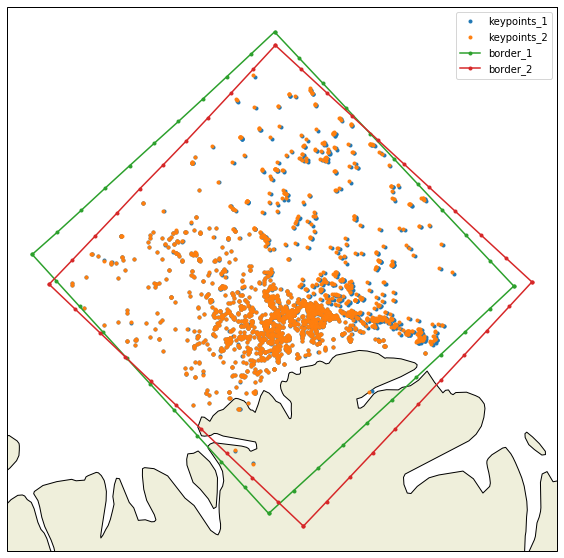

In [4]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

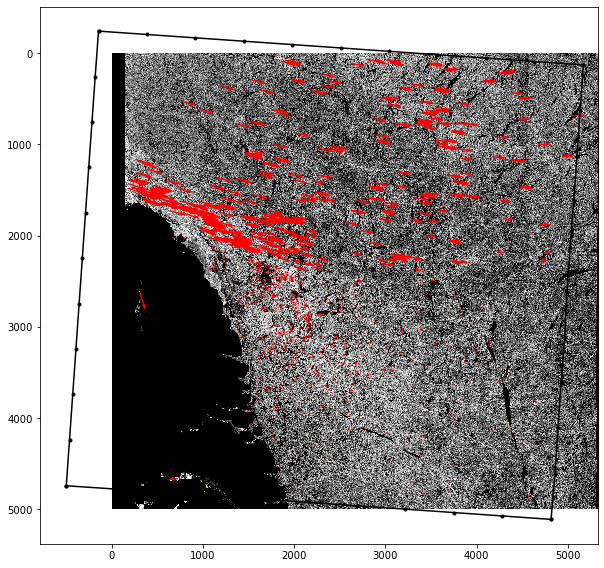

In [5]:
# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(10,10))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.2)
plt.plot(n1lon2b, n1lat2b, 'k.-')
plt.show()

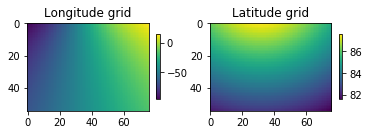

In [6]:
# Create lon/lat grids in Polar stereographic coordinate system 
# Extent of the grid roughly corresponds to the extent of the image_1

# projection (https://epsg.io/3413)
srs = NSR(3413)

# region of interest
d = Domain(srs.wkt, '-lle %f %f %f %f -tr 500 500' % (
    lon1b.min(),
    lat1b.min(),
    lon1b.max(),
    lat1b.max()))

# lon/lat grids in polar stereographic projection covering image_1
lon1pm, lat1pm = d.get_geolocation_grids(20)
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

In [7]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4())


 Pattern matching - OK! (  6 sec)


In [8]:
# image_1 in stereographic projection
n1.reproject(d)
n1b1pro = n1[1]
n1.undo()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


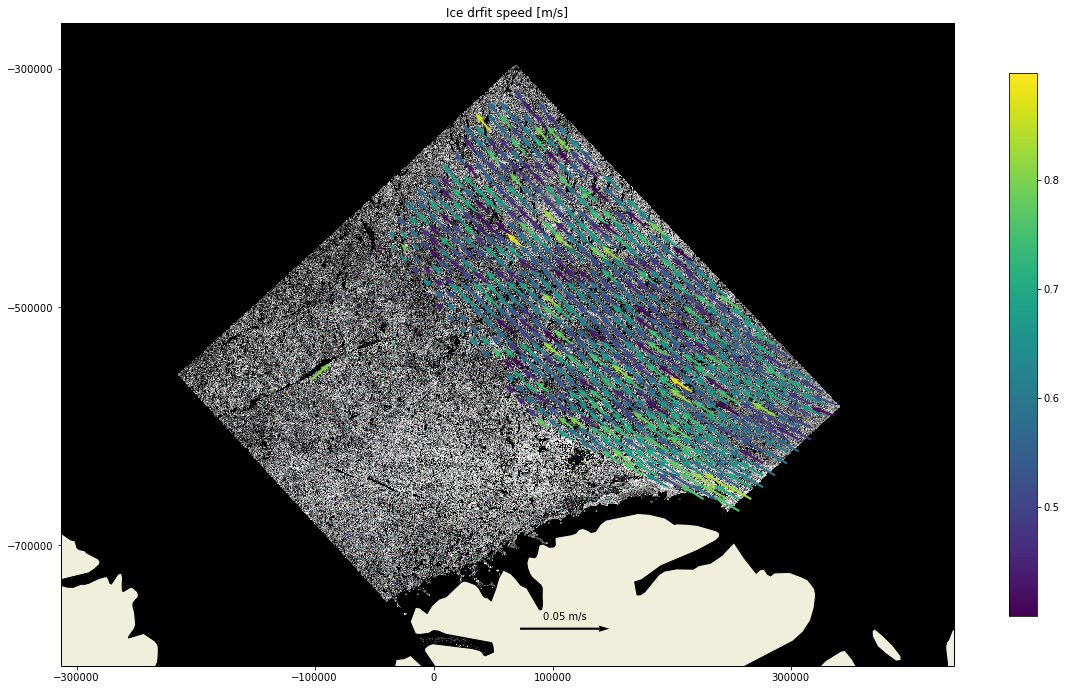

In [9]:
# compute ice drift speed [m/s]
delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
u = upm / delta_t
v = vpm / delta_t

# plot valid vectors in Polar stereographic projection
gpi = (rpm > 0.4) 
# X/Y grids in polar stereographic projection covering image_1
x1pm, y1pm = d.get_geolocation_grids(20, dst_srs=srs)

# spacial reference for plotting
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)

plt.figure(figsize=(20,20))
ax = plt.axes(projection=crs)

ax.imshow(n1b1pro, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv=ax.quiver(x1pm[gpi], y1pm[gpi], u[gpi], v[gpi], rpm[gpi], scale=0.5)
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

In [ ]:
## Generate test files for simple.py
"""
filenames = [
    'S1B_EW_GRDM_1SDH_20200123T120618_20200123T120718_019944_025BA1_D4A2.SAFE',
    'S1B_EW_GRDM_1SDH_20200125T114955_20200125T115055_019973_025C81_EC1A.SAFE'
]
crop_params = [
    (1800,4400,1000,1000),
    (2400,4600,1000,1000),
]

for f,c in zip(filenames, crop_params): 
    n = Nansat(f)
    n.reproject_gcps()
    n.vrt.tps = True
    n.crop(*c)
    n.export(f[:32]+'.tif', bands=['sigma0_HV'], driver='GTiff')
#"""